In [1]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    load_sim_results,
    merge_results,
    graph_metrics,
    graph_relative_to_ideal,
)

In [2]:
# Set this to False if you want to save the figures you generate
DEBUG = True

# Experimental analysis

## Examining the homogenization of content creators

In [4]:
results = merge_results([
    "exps/clean/batch_1", "exps/clean/batch_2", "exps/clean/batch_3", "exps/clean/batch_4", "exps/clean/batch_5",
    "exps/clean/batch_6", "exps/clean/batch_7", "exps/clean/batch_8"])

In [5]:
# make relative to first timestep
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
for m in model_keys:
    x = np.array(results['creator_item_homo'][m])
    x = x - x[:, 0][:, np.newaxis]
    results['creator_item_homo'][m] = x

In [6]:
# readable legend keys
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content filtering",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

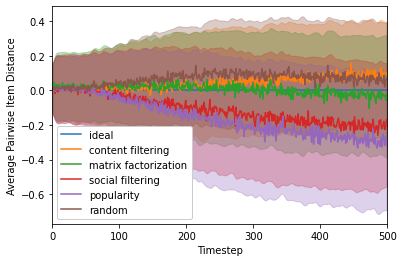

In [7]:
# graph_metrics(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0)
graph_relative_to_ideal(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0, absolute_measure=True)
plt.xlim(0, 500)
plt.legend(facecolor='white', framealpha=1, loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Average Pairwise Item Distance")
if not DEBUG:
    plt.savefig("figures/creator_repeated_item_homo.pdf")

In [8]:
from scipy.stats import dirichlet

In [9]:
ideal_profs= np.array(results['creator_profiles']['ideal'])

In [10]:
num_sims, num_steps, num_creators, num_attrs = ideal_profs.shape

In [11]:
def avg_creator_entropy(creator_profs):
    """ Takes creators array (row = creator, col = attributes)
        and calculates average Dirichlet entropy across all creators
    """
    num_creators = creator_profs.shape[0]
    avg_entropy = 0
    for i in range(num_creators):
        # 0.1 multiplier is from the item-generating process
        avg_entropy += dirichlet.entropy(creator_profs[i, :] * 0.1) / num_creators
    return avg_entropy

In [12]:
def calc_avg_entropy_per_timestep(results, model_keys, num_trials, num_timesteps):
    new_results = {}
    new_results['avg_creator_entropy'] = {}
    for model_key in model_keys:
        entropies = np.zeros((num_trials, num_timesteps))
        creator_profs = np.array(results['creator_profiles'][model_key])
        for i in range(num_trials):
            for j in range(num_timesteps):
                entropies[i, j] = avg_creator_entropy(creator_profs[i, j, :])
        new_results['avg_creator_entropy'][model_key] = entropies
    return new_results

In [13]:
start_entropy = avg_creator_entropy(ideal_profs[0, 0, :])
end_entropy = avg_creator_entropy(ideal_profs[0, 499, :])
print("Average entropy at start of sim: ", start_entropy)
print("Average entropy at end of sim: ", end_entropy)

Average entropy at start of sim:  -4178.63231431025
Average entropy at end of sim:  -299684.43404451216


In [14]:
entropy_results = calc_avg_entropy_per_timestep(results, model_keys, num_sims, 500)

/home/mattsun/anaconda3/envs/trecs_exp/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


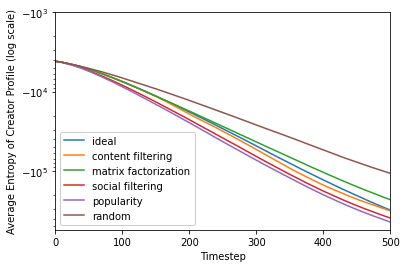

In [15]:
# graph_metrics(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0)
graph_metrics(entropy_results, "avg_creator_entropy", model_keys, id_to_readable)
plt.xlim(0, 500)
plt.legend(facecolor='white', framealpha=1, loc='lower left')
plt.yscale("symlog", subsy=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks([-1000, -10000, -100000])
plt.xlabel("Timestep")
plt.ylabel("Average Entropy of Creator Profile (log scale)")
plt.savefig("figures/creator_repeated_entropy.pdf")

In [16]:
# calculate Dirichlet moment
def average_item(dirichlet_params, multiplier = 0.1):
    """
    Calculate the average item profile for a given vector of parameters
    for the Dirichlet distribution. 
    Multiplier is set to 0.1 for sparsity.
    """
    a0 = (multiplier * dirichlet_params).sum()
    return (multiplier * dirichlet_params) / a0

def item_avg_range_simulated(dirichlet_params, multiplier = 0.1, seed = 1234):
    """
    Calculate the per-property interquartile range
    Multiplier is set to 0.1 for sparsity.
    """
    # sample 1,000
    rng = np.random.default_rng(seed)
    items = rng.dirichlet(dirichlet_params * multiplier, size=10000)
    print(items.shape)
    q1 = np.percentile(items, 5, interpolation = 'midpoint', axis=0)
    q3 = np.percentile(items, 95, interpolation = 'midpoint', axis=0)
    # make relative to mean
    avg = items.mean(axis=0)
    return avg, np.vstack([avg - q1, avg - q3]) 

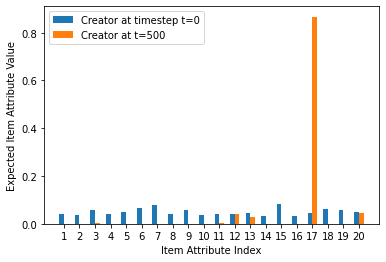

In [17]:
width = 0.3
plt.bar(np.arange(20), average_item(ideal_profs[0, 0, 0, :]), width, label="Creator at timestep t=0")
# plt.ylim(0, 0.8)
plt.bar(np.arange(20) + width, average_item(ideal_profs[0, 499, 0, :]), width, label="Creator at t=500")
plt.xticks(np.arange(20) + width/2, np.arange(20)+1)
plt.xlabel("Item Attribute Index")
plt.ylabel("Expected Item Attribute Value")
plt.legend()
if not DEBUG:
    plt.savefig("figures/creator_attribute_gen.pdf")